# Malaria Project - DenseNet Implementation
## Detecting Malaria cells using CNN and TF 2.0


### By:
- Lukas Wagner s0556753
- Laila Westphal s0556469




## Breakdown of this notebook: 

1. [Loading the dataset](#Imports): Load the data and import the libraries.
2. [Data Preprocessing](#Preprocessing): 
  * Reading the images and labels into 2 folders(Parasitized,Uninfected).
  * Plotting one Parasitized and one Uninfected image with their respective labels.
  * Normalizing the image data.
  * Train, test split
5. [Image Augmentation](#Image-Augmentation): Augment the train and validation data using ImageDataGenerator
4. [Creating the Model](#Create-DenseNet): Create a CNN model in KERAS using the DenseNet architecture.
5. [Training the DenseNet](#Train-DenseNet)
4. [Evaluation](#Evaluate-DenseNet-Accuracy): Display the plots from the training history.
5. [Submission](#Save-Results-To-CSV): Run predictions with model.predict(, and create confusion matrix).



## Introduction
## Kernel 2: Keras Densenet Malaria
### By: Wentz, V.
Source:https://www.kaggle.com/vinicioswentz/keras-densenet-malaria


#### Data Augmentation:
- Done using the Imgaug library that provides support for opening, editing and saving many different data formats
- The quantity of the "Parasitized" data is being quadrupled.
- The quantity of the "Uninfected" data is being tripled.

#### Data-Split:
The data in this kernel is being split into training, evaluation and test data:
   - training-data: 80%
   - evaluation-data: 10%
   - test-data: 10%

#### Used CNN-Architecture:

`DenseNet121()` - by Keras. For further information please see the "Malaria Project - Theoretical Background.ipynb". It contains a small discussion on the paper, which the Keras-provided CNN-Architecture Implementation is referencing.

## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
INPUT_SHAPE = (50, 50, 3)
INFECTED = listdir('data/cell_images/Parasitized/') 
UNINFECTED = listdir('data/cell_images/Uninfected/')

## Preprocessing

In [3]:
data = []
labels = []

def preprocess_images():
    
    for i in INFECTED:
        if i.endswith('.png'):         

            image = cv2.imread("data/cell_images/Parasitized/"+i)
            image_array = Image.fromarray(image , 'RGB')
            data.append(np.array(image_array))
            labels.append(1)


    for u in UNINFECTED:
        if u.endswith('.png'):

            image = cv2.imread("data/cell_images/Uninfected/"+u)
            image_array = Image.fromarray(image , 'RGB')
            data.append(np.array(image_array))
            labels.append(0)
            
            
preprocess_images()

## Visualize data
 Show one cell from each class.

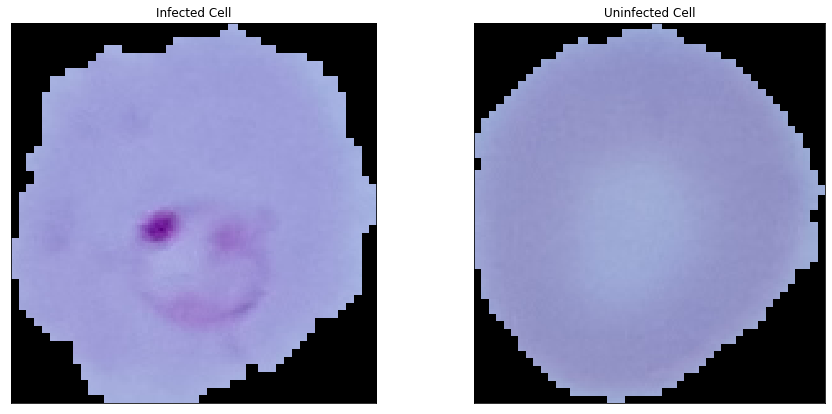

In [4]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(data[0])
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(data[15000]) #indexs of uninfected cells are above 14000 
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

## Visualize Data Distribution

In [ ]:
import matplotlib.ticker
unique_vals, counts = np.unique(labels, return_counts = True)
plt.figure(figsize = (7,7))
print(counts)
plt.bar(unique_vals, counts/counts.sum());
print(counts.sum())
plt.yticks(vals, ["{}".format(x) for x in vals])
plt.xticks([])
plt.title('Distribution of images')
plt.show()

## Image Augmentation
Resize, flip, blur, rotate and vary the color of the images.

In [6]:
import imgaug.augmenters as iaa

def augment_images(data, labels):
    images_aug = []
    labels_aug= []
    
    resized_images = iaa.Resize({"height": 50, "width": 50})(images=data)
    flipped_images = iaa.Fliplr(1.0)(images=data)
    blurred_images = iaa.GaussianBlur(sigma=(0, 1.0))(images=data)
    colorchanged_images = iaa.LinearContrast(alpha=(0.25, 1.75),per_channel=True)(images=data)
    rotated_images = iaa.Affine(rotate=(-45, 45))(images=data)

    lists_aug = [resized_images, flipped_images, blurred_images, colorchanged_images]

    counter=0
    for list_aug in lists_aug:
        for image in list_aug:
            images_aug.append(np.array(image))
            labels_aug.append(labels[counter])
            counter+=1
            if counter >= len(labels):
                counter = 0
            
    return images_aug, labels_aug

images_aug, labels_aug = augment_images(data, labels)
data+=images_aug
labels+=labels_aug

In [7]:
#just for debugging
print(len(images_aug))
print(len(data))
print(len(labels))

110228
137785
137785


## Visualize Augmented Data

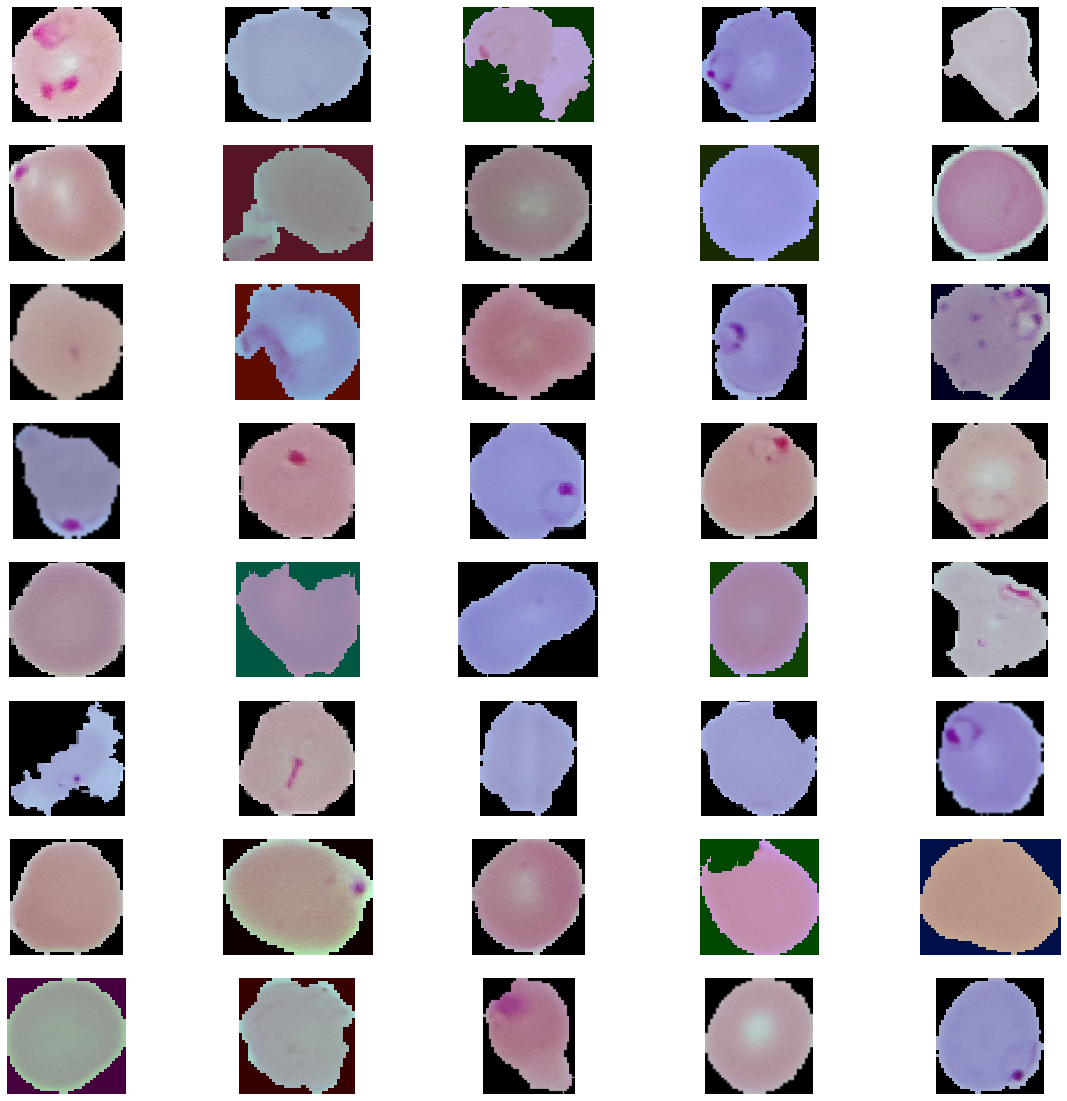

In [8]:
plt.figure(figsize = (20, 20))
for i in range(40):
    r = np.random.randint(len(images_aug))
    ax = plt.subplot(8, 5, i+1)
    ax.axis('off')
    plt.imshow(images_aug[r])    

## Save Data To NYP 

In [ ]:
cells = np.array(data)
labels = np.array(labels)

np.save('cells' , cells)
np.save('labels' , labels)

## Load Data From NYP 

In [ ]:
cells = np.load("cells.npy")
labels = np.load("labels.npy")

## Create DenseNet

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169, DenseNet201, DenseNet121 #just in case
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import losses, optimizers, activations, metrics

#### DenseNet Class
`create_model()` builds the CNN model with the 121 layers counting DenseNet version of Keras plus some extra layers to ... 
With the parameters: lossfuntion, optimizer and metric the model will be compiled and returned.

In [ ]:
class DenseNet:
    def __init__(self, loss, optmizer, metrics):
        self.loss = loss
        self.optimizer = optmizer
        self.metrics = metrics
    
    def create_model(self, output_space: int) -> Model:
        base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False)
        out0 = base_model.output
        out1 = GlobalMaxPooling2D()(out0)
        out2 = GlobalAveragePooling2D()(out0)
        out3 = Flatten()(out0)
        out = Concatenate(axis=-1)([out1, out2, out3])
        out = Dropout(0.5)(out)
        
        predictions = Dense(output_space, activation="sigmoid")(out)
        
        model = Model(inputs=base_model.input, outputs=predictions)

        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        #model.summary() interesting but bad readability
        return model

#### Calculate Learning Rate
The function `step_decay(epoch)` calculates the learning rate for each epoch, which is then scheduled by the `LearningRateScheduler`. When the learning rate stagnates the learning rate gets reduced by `ReduceLROnPlateau`.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate = LearningRateScheduler(step_decay)

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_delta=1e-7)

callbacks_list = [learning_rate, rlrp]

* `losses.binary_crossentropy`: binary classification because there are only two labels: "uninfected" and "parasitized" cells.
* `optimizers.Adam`: (A Method for Stochastic Optimization) Gradient-based optimization.
* `mertrics=["accuracy"]`: Judge the performance of the model by accuracy.

In [ ]:
model = DenseNet(
    losses.binary_crossentropy,
    optimizers.Adam(lr = 10e-5),
    ["accuracy"]
).create_model(1)

## Split Train and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , test_size = 0.2 , random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y ,test_size = 0.5 , random_state = 111)

In [ ]:
plt.figure(1 , figsize = (15 ,5))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['train labels','eval labels','test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

print("size of training data set is {}".format((train_x.shape[0])))
print("size of validating data set is {}".format(eval_x.shape[0]))
print("size of testing data set is {}".format(test_x.shape[0]))

## Train DenseNet

In [ ]:
history = model.fit(train_x, train_y,
          validation_data=(eval_x, eval_y),
          batch_size=2,
          epochs=3,
          verbose=1)

## Save DenseNet To File

In [ ]:
model.save('cells.h5')

## Load DenseNet From File
Returns a compiled keras model.

In [ ]:
model = load_model('cells.h5')

## Evaluate DenseNet Accuracy

In [ ]:
accuracy = model.evaluate(test_x, test_y, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

## Visualize Training

In [ ]:
def show_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss per Epoche')
    ax[0].plot(history.epoch, history.history["loss"], label="Training")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation")
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].set_title('Accuracy per Epoche')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation")
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].legend()
    
show_training_history(history)

## Predict Test Data Results

In [ ]:
results = model.predict(test_x)

In [ ]:
results = np.argmax(results,axis=1)
results = pd.Series(results,name="Label")

In [ ]:
#just for debugging
len(results)

## Visualize Prediction Results

In [ ]:
#from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y , results)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['uninfected', 'parasitized']); ax.yaxis.set_ticklabels(['parasitized', 'uninfected']);

Plots random prediction results and gives a title to the falsely predicted call images.

In [ ]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    if((test_y[r[0]]) != (results[r[0]])):
        plt.title('true {} : pred {}'.format(test_y[r[0]] , results[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()


## Save Results To CSV

In [ ]:
submission = pd.concat([pd.Series(range(1,9647),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

* change sigmoid to relu and get rid of dropout
* try DensNet2xx
* try shape (64, 64, 3)
* Thesis: only parasitized images need to be multiplied by data augmentation, cuz of small filter-relevance
* #seq = iaa.Sequential([])


## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Malaria Project - Implementation<br/>
Detecting Malaria cells using CNN and TF 2.0 <br/>
by Lukas Wagner, Laila Westphal <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 Lukas Wagner, Laila Westphal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Acknowledgements
Wentz, V. (April 2019). Keras Densenet Malaria (Jupyter Notebook). Retrieved from https://www.kaggle.com/vinicioswentz/keras-densenet-malaria